# All Model Errors

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/tommy/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm

mpl.rcParams['figure.dpi'] = 150

In [3]:
# data_dir = Path('data/')
data_dir = Path('/cats/datastore/data/')

assert data_dir.exists()

In [4]:
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis.evaluation import join_true_pred_da
from src.models import load_model

# Read in the data

In [5]:
EXPERIMENT =        'one_timestep_forecast'
TRUE_EXPERIMENT =   'one_timestep_forecast'
TARGET_VAR =        'discharge_spec'
STATIC_DATA_FILE =  'data.nc' # '2020_04_23:112630_data.nc_'
DYNAMIC_DATA_FILE = 'data.nc'
N_EPOCHS = 100

# assert (data_dir / f"models/{EXPERIMENT}").exists()
assert (data_dir / f"RUNOFF/features/{TRUE_EXPERIMENT}").exists()

In [6]:
# read in the training data
ds = xr.open_dataset(data_dir / f'RUNOFF/features/{TRUE_EXPERIMENT}/{DYNAMIC_DATA_FILE}')

# static_ds = xr.open_dataset(Path(f'data/features/static/data.nc'))
all_static = xr.open_dataset(data_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

ds['station_id'] = ds['station_id'].astype(int)

In [7]:
catchment_ids = [int(c) for c in ["12002", "15006", "27009", "27034", "27041", "39001", "39081", "43021", "47001", "54001", "54057", "71001", "84013",]]
catchment_names = ["Dee@Park", "Tay@Ballathie", "Ouse@Skelton", "Ure@Kilgram", "Derwent@Buttercrambe", "Thames@Kingston", "Ock@Abingdon", "Avon@Knapp", "Tamar@Gunnislake", "Severn@Bewdley", "Severn@Haw", "Ribble@Samlesbury", "Clyde@Daldowie"]
station_map = dict(zip(catchment_ids, catchment_names))

# Read AWS Trained Models

In [8]:
print([d.name for d in (data_dir/'runs/').iterdir()])
print([d.name for d in (data_dir/'runs').glob('*_less_vars*/*E015.csv')])

['ealstm_less_vars_2004_1607_1334', 'lstm_less_vars_1307_1717', 'ealstm_less_vars_2004_1707_1424', 'lstm_less_vars_2004_1507_1028', 'train_data.h5', 'train_data_scaler.p', 'lstm_ALL_vars_2004_2210_1035', 'lstm_all_vars_1998_2008_2210_110347', 'lstm_all_vars_1998_2008_2210_110727', 'lstm_all_vars_1998_2008_nh_2310_101443', 'lstm_all_vars_1998_2008_nh_2310_142625']
['results_lstm_less_vars_1307_1717_E015.csv', 'results_ealstm_less_vars_2004_1707_1424_E015.csv', 'results_lstm_less_vars_2004_1507_1028_E015.csv']


In [9]:
# lstm_less_vars = pd.read_csv(data_dir / "RUNOFF/lstm_less_vars/results_lstm_less_vars_1307_1717_E015.csv")
lstm_less_vars = pd.read_csv(data_dir / "runs/lstm_less_vars_2004_1507_1028/results_lstm_less_vars_2004_1507_1028_E015.csv")
lstm_more_vars = pd.read_csv(data_dir / "runs/lstm_ALL_vars_2004_2210_1035/results_lstm_ALL_vars_2004_2210_1035_E015.csv")

lstm_less_vars["time"] = pd.to_datetime(lstm_less_vars["time"])
lstm_more_vars["time"] = pd.to_datetime(lstm_more_vars["time"])

# RECENT MODEL RESULTS
lstm_df3 = pd.read_csv(data_dir / "runs/lstm_all_vars_1998_2008_nh_2310_101443/test/model_epoch030/lstm_all_vars_1998_2008_nh_2310_101443_E030.csv")
lstm_df3["time"] = pd.to_datetime(lstm_df3["time"])

In [10]:
ealstm_less_vars = pd.read_csv(data_dir / "runs/ealstm_less_vars_2004_1707_1424/results_ealstm_less_vars_2004_1707_1424_E015.csv")
ealstm_less_vars["time"] = pd.to_datetime(ealstm_less_vars["time"])

In [11]:
lstm_preds = lstm_df3.set_index(["station_id", "time"]).to_xarray()
ealstm_preds = ealstm_less_vars.set_index(["station_id", "time"]).to_xarray()

In [12]:
lstm_preds

<xarray.Dataset>
Dimensions:     (station_id: 669, time: 4018)
Coordinates:
  * station_id  (station_id) int64 1001 2001 2002 3003 ... 102001 106001 107001
  * time        (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2008-12-31
Data variables:
    Unnamed: 0  (station_id, time) int64 8036 8037 8038 ... 32141 32142 32143
    obs         (station_id, time) float64 2.14 1.81 4.57 3.3 ... 1.18 1.04 0.94
    sim         (station_id, time) float64 1.638 2.099 2.863 ... 0.9119 0.8254

# FUSE Data

In [13]:
all_paths = [d for d in (data_dir / "RUNOFF/FUSE/Timeseries_SimQ_Best/").glob("*_Best_Qsim.txt")]

if not (data_dir / "RUNOFF/ALL_fuse_ds.nc").exists():
    all_dfs = []
    for txt in tqdm(all_paths):
        df = pd.read_csv(txt, skiprows=3, header=0)
        df.columns = [c.rstrip().lstrip() for c in df.columns]
        df = df.rename(columns={"YYYY": "year", "MM": "month", "DD": "day"})
        df["time"] = pd.to_datetime(df[["year", "month", "day"]])
        station_id = int(str(txt).split("/")[-1].split("_")[0])
        df["station_id"] = [station_id for _ in range(len(df))]
        df = df.drop(["year", "month", "day", "HH"], axis=1).set_index(["station_id", "time"])
        all_dfs.append(df)
        
    fuse_ds = pd.concat(all_dfs).to_xarray()
    fuse_ds.to_netcdf(data_dir / "RUNOFF/ALL_fuse_ds.nc")
    
else:
    fuse_ds = xr.open_dataset(data_dir / "RUNOFF/ALL_fuse_ds.nc")

In [14]:
fuse_ds = fuse_ds.sel(time=slice('2004-01-01', '2009-01-01'))

In [15]:
# join with observations for stations that exist
obs = (
    ds.sel(station_id=np.isin(ds["station_id"], fuse_ds["station_id"]), time=fuse_ds["time"])["target_var_original"]
).rename("obs")
fuse_data = fuse_ds.sel(station_id=obs.station_id).merge(obs)

In [16]:
fuse_data

<xarray.Dataset>
Dimensions:          (station_id: 519, time: 1827)
Coordinates:
  * station_id       (station_id) int64 1001 2001 2002 ... 101005 102001 106001
  * time             (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2008-12-31
Data variables:
    SimQ_TOPMODEL    (station_id, time) float64 ...
    SimQ_ARNOVIC     (station_id, time) float64 ...
    SimQ_PRMS        (station_id, time) float64 ...
    SimQ_SACRAMENTO  (station_id, time) float64 ...
    obs              (time, station_id) float64 ...

# Match Stations / Times

In [17]:
all_stations_lstm = np.isin(lstm_preds.station_id, fuse_data.station_id)
all_stations_ealstm = np.isin(ealstm_preds.station_id, fuse_data.station_id)

In [18]:
lstm_preds = lstm_preds.sel(station_id=all_stations_lstm, time=fuse_data.time)
ealstm_preds = ealstm_preds.sel(station_id=all_stations_ealstm, time=fuse_data.time)

# Errors

In [19]:
from src.analysis.evaluation import spatial_rmse, spatial_r2, spatial_nse, spatial_bias
from src.analysis.evaluation import temporal_rmse, temporal_r2, temporal_nse
from src.analysis.evaluation import _nse_func, _rmse_func, _r2_func, _bias_func

In [20]:
def error_func(preds_xr: xr.Dataset, error_str: str) -> pd.DataFrame:
    lookup = {
        "nse": _nse_func,
        "rmse": _rmse_func,
        "r2": _r2_func,
        "bias": _bias_func,
    }
    error_func = lookup[error_str]
    
    df = preds_xr.to_dataframe()
    df = df.dropna(how='any')
    df = df.reset_index().set_index("time")

    station_ids = df["station_id"].unique()
    errors = []
    for station_id in station_ids:
        d = df.loc[df["station_id"] == station_id]
        if error_str == "rmse":
            _error_calc = error_func(d["obs"].values, d["sim"].values, n_instances=d.size)
        else:
            _error_calc = error_func(d["obs"].values, d["sim"].values)
        errors.append(_error_calc)

    error = pd.DataFrame({"station_id": station_ids, error_str: errors})
    
    return error

In [21]:
errors = [ 
    error_func(ealstm_preds, "nse").set_index('station_id'),
    error_func(ealstm_preds, "r2").set_index('station_id'), 
    error_func(ealstm_preds, "rmse").set_index('station_id'),
    error_func(ealstm_preds, "bias").set_index('station_id'),
]
ealstm_df = errors[0].join(errors[1].join(errors[2]).join(errors[3])).reset_index()

errors = [ 
    error_func(lstm_preds, "nse").set_index('station_id'),
    error_func(lstm_preds, "r2").set_index('station_id'), 
    error_func(lstm_preds, "rmse").set_index('station_id'),
    error_func(lstm_preds, "bias").set_index('station_id'),
]
lstm_df = errors[0].join(errors[1].join(errors[2]).join(errors[3])).reset_index()

In [22]:
ealstm_nse = (
    error_func(ealstm_preds, "nse")
    .sort_values('nse')
    .reset_index()
    .drop('index', axis=1)
)
lstm_nse = (
    error_func(lstm_preds, "nse")
    .sort_values('nse')
    .reset_index()
    .drop('index', axis=1)
)
ealstm_nse['negative'] = ealstm_nse['nse'] < 0
lstm_nse['negative'] = lstm_nse['nse'] < 0

# FUSE - Calculate from Sim OR Read from their published results

In [23]:
obs = fuse_data["obs"].transpose("station_id", "time")
topmodel = fuse_data["SimQ_TOPMODEL"]
arnovic = fuse_data["SimQ_ARNOVIC"]
prms = fuse_data["SimQ_PRMS"]
sacramento = fuse_data["SimQ_SACRAMENTO"]

In [24]:
RECALCULATE = False

if RECALCULATE:
    # NSE
    top_nse = spatial_nse(obs, topmodel).rename("TOPMODEL")
    vic_nse = spatial_nse(obs, arnovic).rename("VIC")
    prms_nse = spatial_nse(obs, prms).rename("PRMS")
    sac_nse = spatial_nse(obs, sacramento).rename("Sacramento")

    nse = xr.merge([
        top_nse,
        vic_nse,
        prms_nse,
        sac_nse,
    ])
    nse_df = nse.to_dataframe()
    nse_df = static['gauge_name'].to_dataframe().join(nse_df).rename(columns=dict(gauge_name="Name"))
    nse_df.to_csv(data_dir / 'RUNOFF/FUSE_nse_table.csv')
    nse_df.columns = [["nse" for _ in range(len(nse_df.columns))], nse_df.columns]

    # RMSE
    top_rmse = spatial_rmse(obs, topmodel).rename("TOPMODEL")
    vic_rmse = spatial_rmse(obs, arnovic).rename("VIC")
    prms_rmse = spatial_rmse(obs, prms).rename("PRMS")
    sac_rmse = spatial_rmse(obs, sacramento).rename("Sacramento")

    rmse = xr.merge([
        top_rmse,
        vic_rmse,
        prms_rmse,
        sac_rmse,
    ])
    rmse_df = rmse.to_dataframe().drop(columns='time')
    rmse_df.to_csv(data_dir / 'RUNOFF/FUSE_rmse_table.csv')
    rmse_df.columns = [["rmse" for _ in range(len(rmse_df.columns))], rmse_df.columns]

    # R2
    top_r2 = spatial_r2(obs, topmodel).rename("TOPMODEL")
    vic_r2 = spatial_r2(obs, arnovic).rename("VIC")
    prms_r2 = spatial_r2(obs, prms).rename("PRMS")
    sac_r2 = spatial_r2(obs, sacramento).rename("Sacramento")

    r2 = xr.merge([
        top_r2,
        vic_r2,
        prms_r2,
        sac_r2,
    ])
    r2_df = r2.to_dataframe().drop(columns='time')
    r2_df.to_csv(data_dir / 'RUNOFF/FUSE_r2_table.csv')
    r2_df.columns = [["r2" for _ in range(len(r2_df.columns))], r2_df.columns]

    # BIAS
    top_bias = spatial_bias(obs, topmodel).rename("TOPMODEL")
    vic_bias = spatial_bias(obs, arnovic).rename("VIC")
    prms_bias = spatial_bias(obs, prms).rename("PRMS")
    sac_bias = spatial_bias(obs, sacramento).rename("Sacramento")

    bias = xr.merge([
        top_bias,
        vic_bias,
        prms_bias,
        sac_bias,
    ])
    bias_df = bias.to_dataframe()
    bias_df.to_csv(data_dir / 'RUNOFF/FUSE_bias_table.csv')
    bias_df.columns = [["bias" for _ in range(len(bias_df.columns))], bias_df.columns]
    
    print("** Cell Run and NSE Recalculated **")

In [25]:
if RECALCULATE:
    fuse_errors = pd.concat([nse_df, rmse_df, r2_df, bias_df], axis=1)
    try:
        fuse_errors = fuse_errors.drop('time', axis=1, level=1).swaplevel(axis=1).sort_index(axis=1)
    except KeyError:
        pass
    fuse_errors = fuse_errors.rename({"NSE": "nse", "BIAS": "bias", "MSE": "mse"}, axis=1, level=0)
    fuse_errors.to_csv(data_dir / 'RUNOFF/FUSE_errors.csv')
    fuse_errors.to_pickle(data_dir / 'RUNOFF/FUSE_errors.pkl')

    fuse_nse_df = fuse_errors.drop(['bias', 'r2', 'rmse'], axis=1, level=0).droplevel(axis=1, level=0)
    fuse_bias = fuse_errors.drop(['nse', 'r2', 'rmse'], axis=1, level=0).droplevel(axis=1, level=0)
    
    print("** Cell Run and NSE Recalculated **")

In [26]:
if not RECALCULATE:
    ## READ FROM PUBLISHED RESULTS
    gauge_names = static['gauge_name'].to_dataframe()

    def fix_name(string: str):
        string = string.replace("_060", "_TOPMODEL")
        string = string.replace("_230", "_VIC")
        string = string.replace("_342", "_PRMS")
        string = string.replace("_426", "_SACRAMENTO")
        return string

    performance_scores = pd.read_csv(data_dir / "FUSE/Summary_Scores/Best_Scores.txt", skiprows=4)

    # fix the column names
    performance_scores.columns = [fix_name(c) for c in performance_scores.columns]

    # get matching stations
    performance_scores = performance_scores.loc[np.isin(performance_scores["Gauge_ID"], ds["station_id"])]
    
    print("** Cell Run and NSE Read from Disk **")

** Cell Run and NSE Read from Disk **


In [27]:
if not RECALCULATE:
    # NSE
    nse2_df = performance_scores.loc[:, [("ID" in c) or ("NSE" in c) for c in performance_scores.columns]]
    nse2_df = gauge_names.join(nse2_df.set_index("Gauge_ID")).rename({"gauge_name": "Name"}, axis=1)
    nse2_df.columns = [["NSE" for _ in range(len(nse2_df.columns))], [c.replace("NSE_", "") for c in nse2_df.columns]]

    # MSE
    mse2_df = performance_scores.loc[:, [("ID" in c) or ("MSE" in c) for c in performance_scores.columns]]
    mse2_df = gauge_names.join(mse2_df.set_index("Gauge_ID")).rename({"gauge_name": "Name"}, axis=1)
    mse2_df.columns = [["MSE" for _ in range(len(mse2_df.columns))], [c.replace("MSE_", "") for c in mse2_df.columns]]

    # Bias
    bias2_df = performance_scores.loc[:, [("ID" in c) or ("Bias" in c) for c in performance_scores.columns]]
    gauge_id = bias2_df["Gauge_ID"] 
    bias2_df = bias2_df * 100
    bias2_df["Gauge_ID"] = gauge_id
    bias2_df = gauge_names.join(bias2_df.set_index("Gauge_ID")).rename({"gauge_name": "Name"}, axis=1)
    bias2_df.columns = [["BIAS" for _ in range(len(bias2_df.columns))], [c.replace("Relative_Bias_", "") for c in bias2_df.columns]]
    
    
    # JOIN all into one dataframe
    fuse_errors = pd.concat([nse2_df, bias2_df, mse2_df], axis=1)
    fuse_errors = fuse_errors.rename({"NSE": "nse", "BIAS": "bias", "MSE": "mse"}, axis=1, level=0)
    try:
        fuse_errors = fuse_errors.drop('time', axis=1, level=1).swaplevel(axis=1).sort_index(axis=1)
    except KeyError:
        pass

    # for plotting
    fuse_bias = bias2_df.droplevel(axis=1, level=0).rename({"SACRAMENTO": "Sacramento"}, axis=1)
    fuse_nse_df = nse2_df.droplevel(axis=1, level=0).rename({"SACRAMENTO": "Sacramento"}, axis=1)
    
    print("** Cell Run and NSE Read from Disk **")

** Cell Run and NSE Read from Disk **


In [28]:
# fuse_nse2_df = fuse_nse2_df.rename({"SACRAMENTO": "Sacramento"}, axis=1)

display(fuse_nse_df.head())
# display(fuse_nse2_df.head())

,Name,TOPMODEL,VIC,PRMS,Sacramento
station_id,,,,,
1001,Wick at Tarroul,0.755836,0.764714,0.788691,0.806047
2001,Helmsdale at Kilphedir,0.638955,0.674150,0.674432,0.692287
2002,Brora at Bruachrobie,0.692957,0.687312,0.683122,0.702109
3003,Oykel at Easter Turnaig,0.796328,0.787968,0.779536,0.793024
4001,Conon at Moy Bridge,0.726878,0.818241,0.766328,0.785913


# Overall Model Performance Comparison

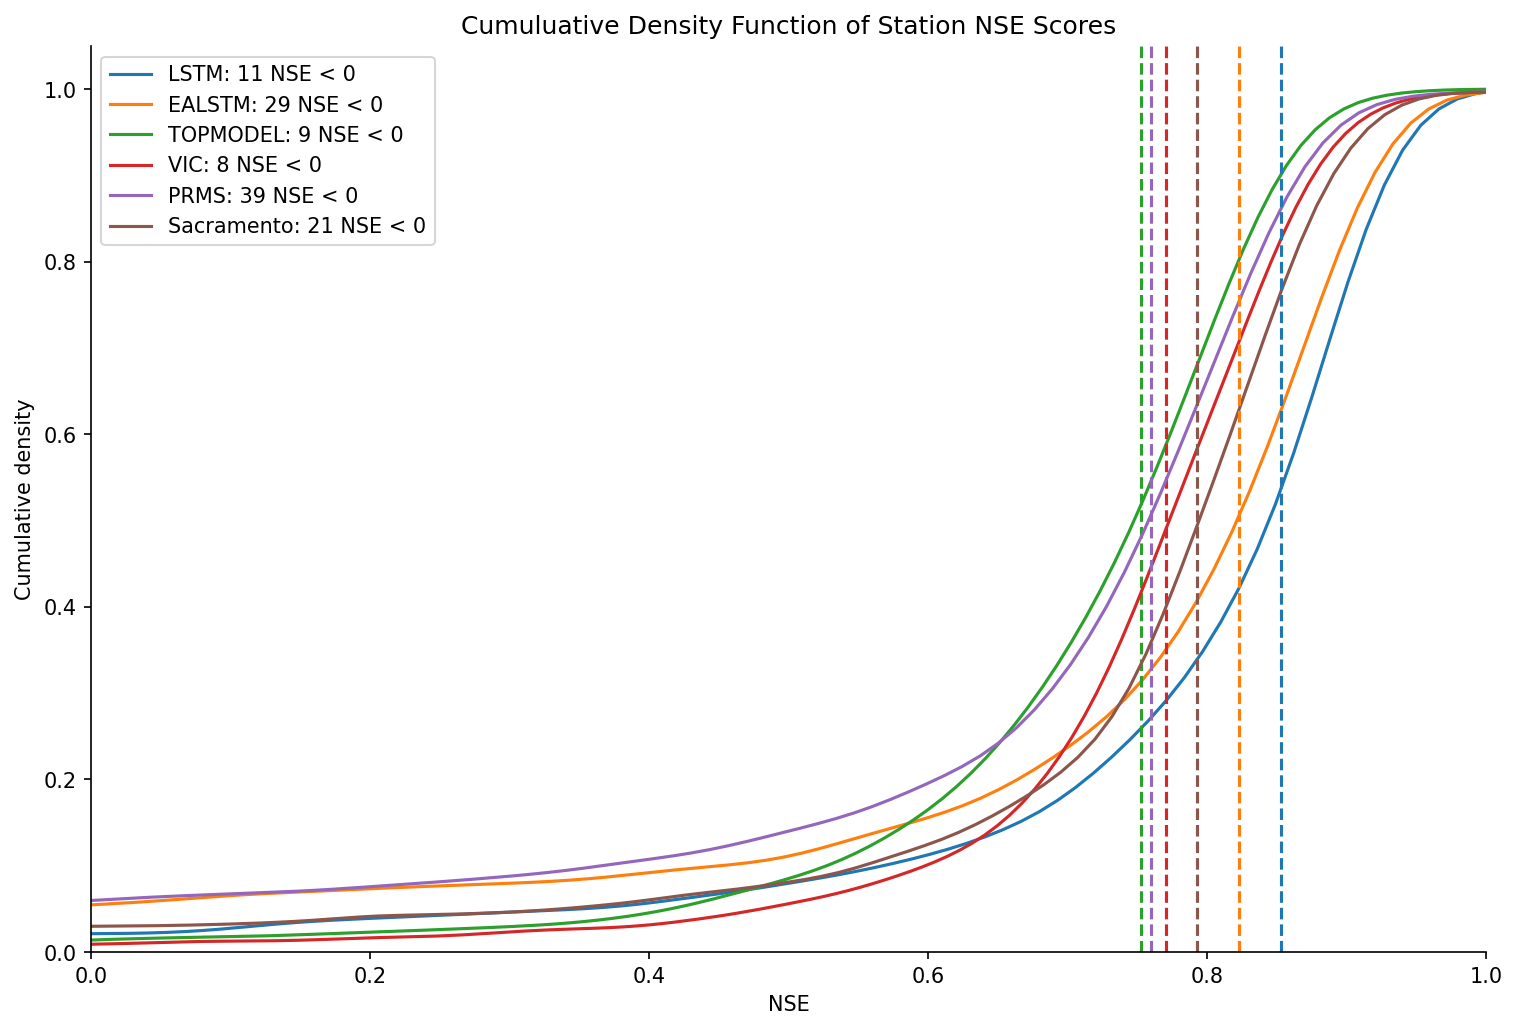

In [29]:
colors = sns.color_palette()

fig, ax = plt.subplots(figsize=(12, 8))
sns.kdeplot(
    lstm_nse['nse'], 
    cumulative=True, 
    legend=False, ax=ax, 
    clip=[-0.5,1], 
    label=f"LSTM: {lstm_nse['negative'].sum()} NSE < 0"
)
sns.kdeplot(
    ealstm_nse['nse'], 
    cumulative=True, 
    legend=False, ax=ax, 
    clip=[-0.5,1], 
    label=f"EALSTM: {ealstm_nse['negative'].sum()} NSE < 0"
)

for conceptual_ix, model in enumerate([c for c in fuse_nse_df.columns if (not "Name" in c) and (not "station" in c)]):
    sns.kdeplot(
        fuse_nse_df[model].dropna(), 
        cumulative=True, 
        legend=False, ax=ax, 
        clip=[-0.5,1], 
        label=f"{model}: {(fuse_nse_df[model] < 0).sum()} NSE < 0"
    )
    plt.legend()
    ax.axvline(fuse_nse_df[model].dropna().median(), ls="--", color=colors[conceptual_ix+2])


ax.axvline(lstm_nse['nse'].median(), ls="--", color=colors[0])
ax.axvline(ealstm_nse['nse'].median(), ls="--", color=colors[1])

ax.set_xlim([-0, 1])
ax.set_xlabel("NSE")
ax.set_ylabel("Cumulative density")
title = f"Cumuluative Density Function of Station NSE Scores"
ax.set_title(title)
sns.despine()

# Bias

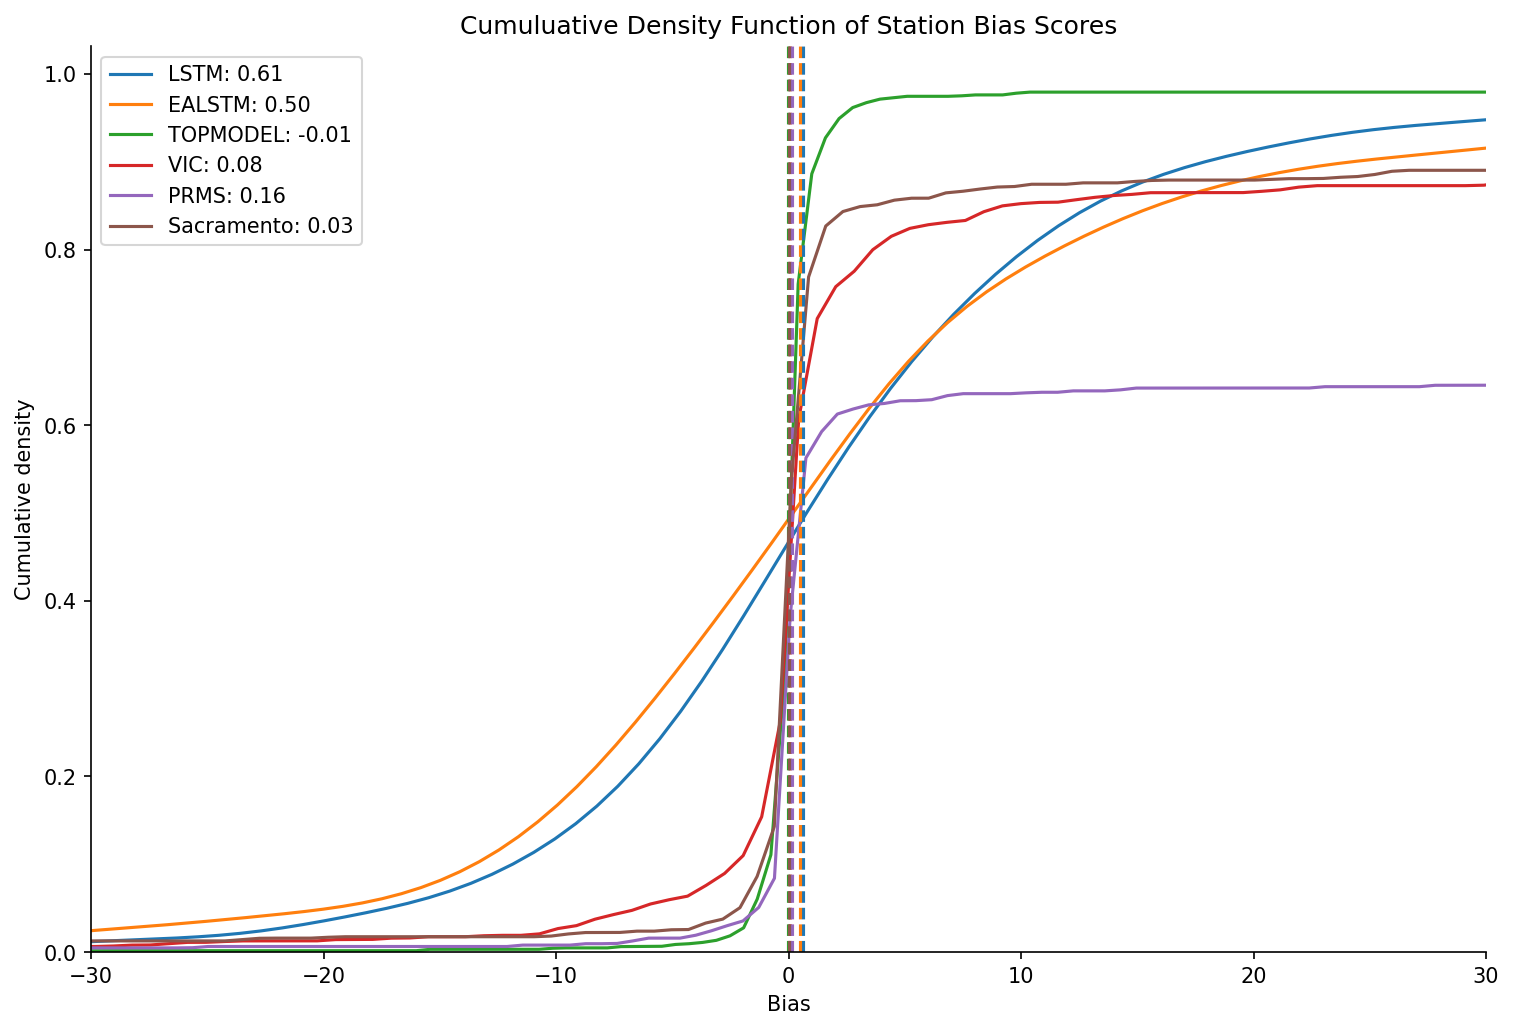

In [30]:
scaled_bias = (fuse_bias * 100).rename({"SACRAMENTO": "Sacramento"}, axis=1)

colors = sns.color_palette()
cumulative = True

fig, ax = plt.subplots(figsize=(12, 8))
sns.kdeplot(
    lstm_df['bias'], 
    cumulative=cumulative, 
    legend=False, ax=ax, 
    clip=[-50, 50], 
    label=f"LSTM: {lstm_df['bias'].median():.2f}"
)
sns.kdeplot(
    ealstm_df['bias'],
    cumulative=cumulative, 
    legend=False, ax=ax, 
    clip=[-50, 50], 
    label=f"EALSTM: {ealstm_df['bias'].median():.2f}"
)

for conceptual_ix, model in enumerate([c for c in fuse_nse_df.columns if (not "Name" in c) and (not "station" in c)]):
    sns.kdeplot(
        scaled_bias[model].dropna(), 
        cumulative=cumulative, 
        legend=False, ax=ax, 
        label=f"{model}: {scaled_bias[model].median():.2f}",
        clip=[-50,50],
    )
    plt.legend()
    ax.axvline(scaled_bias[model].dropna().median(), ls="--", color=colors[conceptual_ix+2])


ax.axvline(lstm_df['bias'].median(), ls="--", color=colors[0])
ax.axvline(ealstm_df['bias'].median(), ls="--", color=colors[1])

ax.set_xlim([-30, 30])
ax.set_xlabel("Bias")

if cumulative:
    ax.set_ylabel("Cumulative density")
    title = f"Cumuluative Density Function of Station Bias Scores"
else:
    title = f"Density of Station Bias Scores"
    ax.set_ylabel("Density")
# ax.axvline(ls="--", color='grey', ) # label="Zero Bias", 
ax.set_title(title)
plt.legend()
sns.despine()

In [31]:
print(f"LSTM Bias: {lstm_df['bias'].mean():.2f}")
print(f"EALSTM Bias: {ealstm_df['bias'].mean():.2f}")

for model in [c for c in fuse_nse_df.columns if (not "Name" in c) and (not "station" in c)]:
    print(f"{model} Bias: {fuse_bias[model].dropna().mean():.2f}")

LSTM Bias: 3.34
EALSTM Bias: 5.02
TOPMODEL Bias: -0.46
VIC Bias: 2.35
PRMS Bias: 8.31
Sacramento Bias: 1.91


# Tables

In [32]:
process_errors = pd.read_csv(data_dir / "RUNOFF/jules_classic.csv")

classic = process_errors.loc[process_errors["Model"] == "Classic", :].drop('Model', axis=1)
classic = classic.rename(columns={"ID": "Station ID"}).set_index("Station ID")
classic.columns = [["CLASSIC" for _ in range(len(classic.columns))], classic.columns]

jules = process_errors.loc[process_errors["Model"] == "Jules", :].drop('Model', axis=1)
jules = jules.rename(columns={"ID": "Station ID"}).set_index("Station ID").drop("Name", axis=1)
jules.columns = [["JULES" for _ in range(len(jules.columns))], jules.columns]

process_errors = pd.concat([classic, jules], axis=1)
process_errors.to_pickle(data_dir / "RUNOFF/process_models.pkl")
process_errors

CLASSIC             JULES      
                                  Name   NSE  Bias   NSE  Bias
Station ID                                                    
12002                     Dee at Park   0.55  -3.4  0.51 -20.0
15006                Tay at Ballathie   0.46  -7.7  0.64 -15.0
27009                 Ouse at Skelton   0.80   3.1  0.69 -18.0
27034           Ure at Kilgram Bridge   0.78   2.8  0.75 -19.0
27041         Derwent at Buttercrambe   0.65  -5.3  0.49 -27.0
39001              Thames at Kingston   0.81  -5.9  0.82 -11.0
39081                 Ock at Abingdon   0.80 -13.6 -0.21 -63.0
43021              Avon at Knapp Mill   0.60 -17.6 -0.07 -20.0
47001             Tamar at Gunnislake   0.82   0.6  0.63 -18.0
54001               Severn at Bewdley   0.66   4.6  0.61  -7.0
54057            Severn at Haw Bridge   0.78   2.1  0.72 -14.0
71001            Ribble at Samlesbury   0.73   0.4  0.74 -18.0
84013               Clyde at Daldowie   0.80  -2.5  0.82 -24.0

In [33]:
if RECALCULATE:
    fuse_nse = fuse_errors.drop(["rmse", "bias", "r2"], axis=1, level=0).droplevel(axis=1, level=0)
    fuse_bias = fuse_errors.drop(["rmse", "nse", "r2"], axis=1, level=0).droplevel(axis=1, level=0)

    fuse_rmse = fuse_errors.drop(["nse", "bias", "r2"], axis=1, level=0).droplevel(axis=1, level=0)
    fuse_r2 = fuse_errors.drop(["rmse", "bias", "nse"], axis=1, level=0).droplevel(axis=1, level=0)
else:
    fuse_nse = fuse_errors.drop(["MSE", "BIAS"], axis=1, level=0).droplevel(axis=1, level=0)
    fuse_bias = fuse_errors.drop(["NSE", "MSE"], axis=1, level=0).droplevel(axis=1, level=0)
    
fuse_nse = fuse_nse.join(fuse_errors.iloc[:, 0]).rename({("Name", "nse"): 'Name'}, axis=1).iloc[:, :-1]
fuse_bias = fuse_bias.join(fuse_errors.iloc[:, 0]).rename({("Name", "nse"): 'Name'}, axis=1).iloc[:, :-1]

if RECALCULATE:
    fuse_rmse = fuse_rmse.join(fuse_errors.iloc[:, 0]).rename({("Name", "nse"): 'Name'}, axis=1).iloc[:, :-1]
    fuse_r2 = fuse_r2.join(fuse_errors.iloc[:, 0]).rename({("Name", "nse"): 'Name'}, axis=1).iloc[:, :-1]

    fuse_r2.head()

KeyError: "labels ['MSE' 'BIAS'] not found in level"

In [ ]:
# NSE
nse = fuse_nse_df.join(
    ealstm_df.set_index("station_id")["nse"].rename("EALSTM")
)
nse = nse.join(
    lstm_df.set_index("station_id")["nse"].rename("LSTM")
)

if RECALCULATE:
    # RMSE
    rmse = fuse_rmse.join(
        ealstm_df.set_index("station_id")["rmse"].rename("EALSTM")
    )
    rmse = rmse.join(
        lstm_df.set_index("station_id")["rmse"].rename("LSTM")
    )
    rmse['Name'] = nse["Name"]
    rmse = rmse[["Name"] + [c for c in rmse.columns if c != "Name"]]

    # R2
    r2 = fuse_r2.join(
        ealstm_df.set_index("station_id")["r2"].rename("EALSTM")
    )
    r2 = r2.join(
        lstm_df.set_index("station_id")["r2"].rename("LSTM")
    )
    r2['Name'] = nse["Name"]
    r2 = r2[["Name"] + [c for c in r2.columns if c != "Name"]]


# BIAS
bias = fuse_bias.join(
    ealstm_df.set_index("station_id")["bias"].rename("EALSTM")
)
bias = bias.join(
    lstm_df.set_index("station_id")["bias"].rename("LSTM")
)
bias['Name'] = nse["Name"]
bias = bias[["Name"] + [c for c in bias.columns if c != "Name"]]

In [ ]:
nse_13 = nse.loc[catchment_ids]
nse_13.index.name = "Station ID"
bias_13 = bias.loc[catchment_ids]
bias_13.index.name = "Station ID"

if RECALCULATE:
    rmse_13 = rmse.loc[catchment_ids]
    rmse_13.index.name = "Station ID"
    r2_13 = r2.loc[catchment_ids]
    r2_13.index.name = "Station ID"

In [ ]:
all_bias = bias_13.join(process_errors.drop(["NSE", "Name"], axis=1, level=1).droplevel(axis=1, level=1))

In [ ]:
all_nse = nse_13.join(process_errors.drop(["Bias", "Name"], axis=1, level=1).droplevel(axis=1, level=1))

In [ ]:
print(all_nse.to_latex(float_format="%.2f"))

In [ ]:
print(all_bias.to_latex(float_format="%.2f"))

In [ ]:
all_nse.to_csv(data_dir / "RUNOFF/all_nse.csv")
all_bias.to_csv(data_dir / "RUNOFF/all_bias.csv")

# Spatial Plots

In [ ]:
def get_error_df(model: str, fuse_errors: pd.DataFrame) -> pd.DataFrame:
    fuse_errors = fuse_errors.drop("Name", axis=1, level=1)
    all_models = ["TOPMODEL", "VIC", "PRMS", "Sacramento"]
    assert model in all_models
    remove_models = [m for m in all_models if m != model]
    error_df = fuse_errors.drop(remove_models, axis=1, level=1).swaplevel(axis=1).sort_index(axis=1).droplevel(axis=1, level=0)
    rename_cols = pd.io.parsers.ParserBase({'names': error_df.columns})._maybe_dedup_names(error_df.columns)
    error_df.columns = [n if n != "nse" else "Name" for n in rename_cols]
    return error_df.rename({"nse.1": "nse"}, axis=1)


vic_errors = get_error_df("VIC", fuse_errors)
prms_errors = get_error_df("PRMS", fuse_errors)
top_errors = get_error_df("TOPMODEL", fuse_errors)
sac_errors = get_error_df("Sacramento", fuse_errors)

vic_errors.head()
fuse_errors.drop("Name", axis=1, level=1)

# Create Geospatial Map

In [ ]:
import geopandas as gpd

shp_path = data_dir / "CAMELS_GB_DATASET/Catchment_Boundaries/CAMELS_GB_catchment_boundaries.shp"
assert shp_path.exists()

# load in the shapefile
geo_df = gpd.read_file(shp_path)
geo_df['ID_STRING'] = geo_df['ID_STRING'].astype('int')
geo_df.crs = {'init' :'epsg:27700'}  # 4277  27700

In [ ]:
# create spatial dataframe
assert lstm_df['station_id'].dtype == geo_df['ID_STRING'].dtype, "Need to be the same type (integer)"
lstm_gdf = gpd.GeoDataFrame(
    geo_df.set_index('ID_STRING').join(lstm_df.set_index('station_id').join(static['p_mean'].to_dataframe()))
)

assert ealstm_df['station_id'].dtype == geo_df['ID_STRING'].dtype, "Need to be the same type (integer)"
ealstm_gdf = gpd.GeoDataFrame(
    geo_df.set_index('ID_STRING').join(ealstm_df.set_index('station_id').join(static['p_mean'].to_dataframe()))
)


# CONCEPTUAL MODELS
assert vic_errors.index.dtype == geo_df['ID_STRING'].dtype, "Need to be the same type (integer)"
vic_gdf = gpd.GeoDataFrame(
    geo_df.set_index('ID_STRING').join(vic_errors.join(static['p_mean'].to_dataframe()))
)

assert prms_errors.index.dtype == geo_df['ID_STRING'].dtype, "Need to be the same type (integer)"
prms_gdf = gpd.GeoDataFrame(
    geo_df.set_index('ID_STRING').join(prms_errors.join(static['p_mean'].to_dataframe()))
)

assert top_errors.index.dtype == geo_df['ID_STRING'].dtype, "Need to be the same type (integer)"
top_gdf = gpd.GeoDataFrame(
    geo_df.set_index('ID_STRING').join(top_errors.join(static['p_mean'].to_dataframe()))
)

assert sac_errors.index.dtype == geo_df['ID_STRING'].dtype, "Need to be the same type (integer)"
sac_gdf = gpd.GeoDataFrame(
    geo_df.set_index('ID_STRING').join(sac_errors.join(static['p_mean'].to_dataframe()))
)


lstm_gdf.crs = {'init' :'epsg:27700'}
ealstm_gdf.crs = {'init' :'epsg:27700'}
vic_gdf.crs = {'init' :'epsg:27700'}
prms_gdf.crs = {'init' :'epsg:27700'}
top_gdf.crs = {'init' :'epsg:27700'}
sac_gdf.crs = {'init' :'epsg:27700'}

## Get UK Boundaries

Get the COUNTY SHAPE data [here:](https://opendata.arcgis.com/datasets/1919db8ffcc5445ea4ba5b8a10acfccd_0.zip?outSR=%7B%22latestWkid%22%3A27700%2C%22wkid%22%3A27700%7D)
```
!wget https://opendata.arcgis.com/datasets/1919db8ffcc5445ea4ba5b8a10acfccd_0.zip
!unzip 1919db8ffcc5445ea4ba5b8a10acfccd_0.zip
!mkdir Counties_and_Unitary_Authorities_April_2019_Boundaries_EW_BFC
!mv Counties* Counties_and_Unitary_Authorities_April_2019_Boundaries_EW_BFC
```

Get all of these shapefiles and merge into one big polygon
```python
uk = gpd.read_file(data_dir / "RUNOFF/Counties_and_Unitary_Authorities_April_2019_Boundaries_EW_BFC/Counties_and_Unitary_Authorities_April_2019_Boundaries_EW_BFC.shp")
uk.plot()

from shapely.ops import unary_union  # cascaded_union, 
uk_bound = unary_union([p for p in uk.geometry])
uk_bound = gpd.GeoSeries(uk_bound)
```

[Link to CRS Discussion](https://communityhub.esriuk.com/geoxchange/2012/3/26/coordinate-systems-and-projections-for-beginners.html#:~:text=If%20you%20work%20with%20UK,that%20you%20should%20know%20about.&text=Web%20Mercator%20is%20a%20PCS,36%20used%20for%20British%20maps)


![title](https://static1.squarespace.com/static/55bb8935e4b046642e9d3fa7/55bb8e8ee4b03fcc125a74c0/55bb8e91e4b03fcc125a7a67/1331725592717/1000w/coordsys_diagram.png)


In [ ]:
assert (data_dir / "RUNOFF/natural_earth_hires/ne_10m_admin_0_countries.shp").exists(), "Download the natural earth hires from https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip"

world = gpd.read_file(data_dir / "RUNOFF/natural_earth_hires/ne_10m_admin_0_countries.shp")
uk = world.query("ADM0_A3 == 'GBR'")
# uk.plot(facecolor='none', edgecolor='k')

In [ ]:
opts = {
    "rmse": {"vmin": 0, "vmax": 1, 'cmap': 'viridis'},   # rmse   
    "rmse_norm": {"vmin": 0, "vmax": 0.5, 'cmap': 'viridis'},   # rmse   
    "nse": {"vmin": 0, "vmax": 1, 'cmap': 'viridis_r'},    # nse   
    "r2": {"vmin": 0, "vmax": 1, 'cmap': 'viridis_r'},    # r2  
    "bias": {"vmin": -30, "vmax": 30, 'cmap': 'RdBu'}    # r2  
}

from typing import List 

def plot_geospatial_data(model_data, model: str, metrics: List[str] = ["rmse", "nse", "bias"]):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    fig, axs = plt.subplots(1, 3, figsize=(15, 8))
    
    for ix, metric in enumerate(metrics):
        ax = axs[ix]
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.2) # depends on the user needs

        # plot the surrounding lines
        uk.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.3)
        # plot the chloropleth
        model_data.to_crs(epsg=4326).plot(metric, ax=ax, legend=True, cax=cax, **opts[metric]);

        ax.set_xlim([-8.2, 2.5])
        ax.axis('off');

        ax.set_title(metric.upper())

    fig.tight_layout(rect=[0, 0.03, 1, 0.965])
    fig.suptitle(f"{model} Model Error", size=14)

In [ ]:
plot_geospatial_data(ealstm_gdf, model="EALSTM")
plot_geospatial_data(lstm_gdf, model="LSTM")

In [ ]:
plot_geospatial_data(vic_gdf, model="VIC", metrics=["nse.1", "bias.1"])
plot_geospatial_data(prms_gdf, model="PRMS", metrics=["nse.1", "bias.1"])
plot_geospatial_data(top_gdf, model="TOPMODEL", metrics=["nse.1", "bias.1"])
plot_geospatial_data(sac_gdf, model="Sacramento", metrics=["nse.1", "bias.1"])